In [2]:
%load_ext autoreload

In [3]:
%matplotlib inline

In [36]:
import matplotlib.pyplot as plt
from scipy import stats, optimize
import numpy as np
import sympy as sym
import seaborn as sns

import inputs
import models
import shooting
import operator
import csv

from __future__ import division
#from sympy import init_printing

sns.set_style("whitegrid")

In [5]:
from estimation_class2 import *

# The Cdf Notebook

This notebook is concerned to the correct way to calcualte the pdf of the size distribution of firms.

## 1. Introduction

Suppose you have some firm size data sorted by firm size:

$$ data_i = [1,1,1.3,2.4,3,3.7,5.4,...] $$

Now notice that some data repeats itself. This may not happen to you, but it certainly happens to me at the begining. Also note that the data points are not evenly spaced - this becomes more of a problem towards the end, where high firms are.

The Probability Distribution Function (pdf) maps points sizes with their frequencies. For example:

$$ 1 \to 100 $$
$$ 2 \to 120 $$
$$ 3 \to 96 $$
$$ ... $$

The Cumulative Distribution Function (cdf) is just the cumulative sum of these:

$$ 1 \to 100 $$
$$ 2 \to 220 $$
$$ 3 \to 316 $$
$$ ... $$

Both of them are normalized to 1 in the end, such that **all of the frequencies add up to 1**. Assuming we have 10,000 firms:

$$ 1 \to 0.010 $$
$$ 2 \to 0.022 $$
$$ 3 \to 0.0316 $$
$$ ... $$

Now looking back at the data, we have two options: 

1. Define some **equaly spaced size bins**: $bins_{eq} = [1,2,3,4...]$
2. Use the data points we have already as **uneven bins**: $bins_{uv} = [1,1,1.3,2.4,3,...]$

And then produce the cdf by counting how many cases we have for each:

**Equal bins:**
$$ 1 \to 2 $$
$$ 2 \to 3 $$
$$ 3 \to 5 $$
$$ ... $$

**Uneven bins:**
$$ 1 \to 2 $$
$$ 1.3 \to 3 $$
$$ 2.4 \to 4 $$
$$ 3 \to 5 $$
$$ ... $$

## 2. Equally spaced bins

For illustration I'm going to use the `SPA05.csv` data, and imported using our class `estimation_class2`.

In [8]:
# Importing data
knots= np.logspace(np.log(0.005), np.log(200.0), 1000,endpoint=True, base=np.e)
est1 = HTWF_Estimation((0.0,1.0), (0.005, 200.0), (0.0,1.0), (0.005, 200.0), 14.0,100000.0,knots)
est1.InitializeFunction()
est1.import_data('SPA05.csv', ID=False, weights=False, logs=False, yearly_w=True)

Let's symplify the analysis by using the first 20 points only:

In [19]:
data20 = np.exp(est1.data[0])[:20]
print data20

[  1.           1.           1.13117066   2.           2.45275035   3.
   3.75317348   4.14527504   5.           5.56558533   6.1056338    7.
   7.56558533   8.18617772   9.           9.75211268  10.36248237
  11.14104372  12.          12.84647887]


The way I constucted the data, each point here represents the mean of the 100th part of the total sample (so 770 firms each). As each data point represents the same number of firms, I do not use weights: each observation represents the same number of firms. 

Your data must be the same, but each point representing an uneven number of firms, and that's why you are using weights.

Say I use equally spaced bins: $[0,1,2,3,4,5,6,7,8,9,10,11,12,13]$. The Cdf (not normalized to one) looks like:

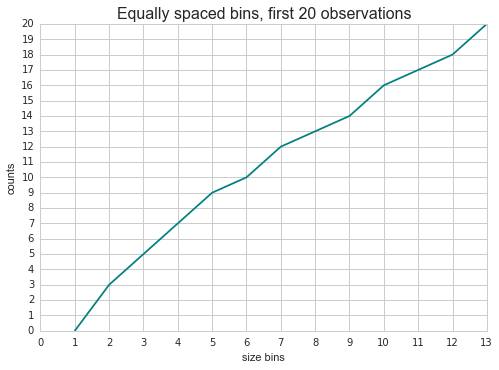

In [63]:
bins_eq = range(14)
counts05, bin_edges05 = np.histogram(data20, bins=bins_eq, normed=False)
cdf = np.cumsum(counts05)
plt.plot(bin_edges05[1:], cdf, color='teal')
plt.xlim(0,13)
plt.yticks(range(21))
plt.xlabel("size bins")
plt.xticks(range(14))
plt.ylabel("counts")
plt.title("Equally spaced bins, first 20 observations", fontsize=16)
plt.show()

As you can guess, if there is no observation in a bin (say $40\le size_i<41$) the line would just jump at that observation.

If we do this with all the data points, being the grid step size 1 worker:

last point is: 1155.7574048


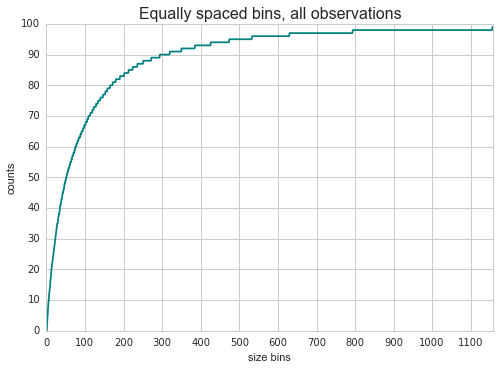

In [76]:
data_all = np.exp(est1.data[0])
print "last point is:", data_all[-1]
topfirm = int(data_all[-1])+1

bins_eq = range(topfirm+1)
counts_eq, bin_edges_eq = np.histogram(data_all, bins=bins_eq, normed=False)
cdf_eq = np.cumsum(counts_eq)
plt.plot(bin_edges_eq[1:], cdf_eq, color='teal')
plt.xlim(0,topfirm+1)
plt.xticks(np.arange(0,1160,100))
plt.xlabel("size bins")
plt.yticks(np.arange(0,110,10))
plt.ylabel("counts")
plt.title("Equally spaced bins, all observations", fontsize=16)
plt.show()

As you can see, it gets very bumpy at the end. In logs these bumps still remain:

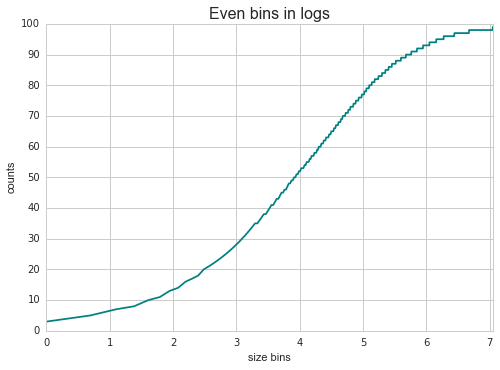

In [111]:
lbins_eq = np.log(bins_eq[1:])
ltop=np.log(topfirm)
lcounts_eq, lbin_edges_eq = np.histogram(np.log(data_all), bins=lbins_eq, normed=False)
lcdf_eq = np.cumsum(lcounts_eq)
plt.plot(lbin_edges_eq[:-1], lcdf_eq, color='teal')
plt.xlim(0,ltop)
plt.xlabel("size bins")
plt.yticks(np.arange(0,110,10))
plt.ylabel("counts")
plt.title("Even bins in logs", fontsize=16)
plt.show()

## 3. Uneven bins

Another way of representing the cdf is amking the bins be each of them 1 observation (in case of weights,the weight). This is what your modification to the code does (plus normalizing counts to one):

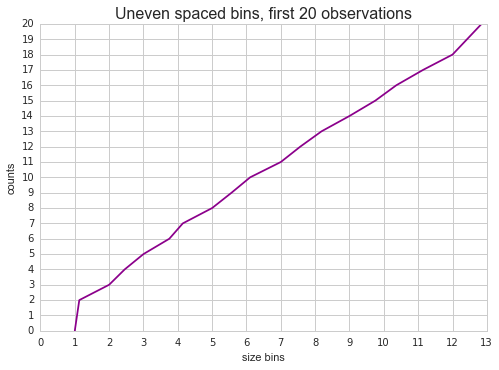

In [92]:
bins_uv = np.hstack((np.array(0),data20[1:])) # gets rid of the same two 1s, substituiting it for 0.
counts05, bin_edges05 = np.histogram(data20, bins=bins_uv, normed=False)
cdf = np.cumsum(counts05)
plt.plot(bin_edges05[1:], cdf, color='darkmagenta')
plt.xlim(0,13)
plt.yticks(range(21))
plt.xlabel("size bins")
plt.xticks(range(14))
plt.ylabel("counts")
plt.title("Uneven spaced bins, first 20 observations", fontsize=16)
plt.show()

Now for all the data:

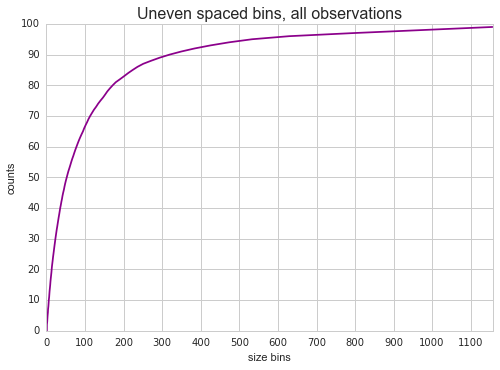

In [81]:
bins_uv = data_all
counts_uv, bin_edges_uv = np.histogram(data_all, bins=bins_uv, normed=False)
cdf_uv = np.cumsum(counts_uv)
plt.plot(bin_edges_uv[1:], cdf_uv, color='darkmagenta')
plt.xlim(0,topfirm+1)
plt.xticks(np.arange(0,1160,100))
plt.xlabel("size bins")
plt.yticks(np.arange(0,110,10))
plt.ylabel("counts")
plt.title("Uneven spaced bins, all observations", fontsize=16)
plt.show()

Much less bumpy! In logs:

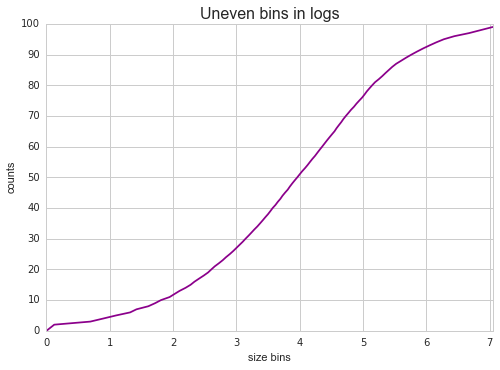

In [103]:
lbins_uv = np.log(data_all)
ltop=lbins_uv[-1]
lcounts_uv, lbin_edges_uv = np.histogram(lbins_uv, bins=lbins_uv, normed=False)
lcdf_uv = np.cumsum(lcounts_uv)
plt.plot(lbin_edges_uv[1:], lcdf_uv, color='darkmagenta', label="uneven")
plt.xlim(0,ltop)
plt.xlabel("size bins")
plt.yticks(np.arange(0,110,10))
plt.ylabel("counts")
plt.title("Uneven bins in logs", fontsize=16)
plt.show()

In a way, uneven bins *interpolate-out* the jumps of the even bin case. That is, for a firm in between a bumpy area, the function steeming form Equal bins would tell the number of cases of the *last observed bin*. 

For exmaple, if I have no observation between 102 and 110, $cdf(105) = cdf(102)$

In the case of uneven bins, it simply *interpolates* from the previous and next observation: $cdf(105) = interp( 
cdf(102),cdf(110) )$

This could mean a difference, but because we only look at the points we already have, it is never an issue. At least, with the data - with the pdf from the model we *do* interpolate.

## 4. What I was doing before

I was counting workers, not firms, in the data. But then I compared that *worker count* pdf with a *firm count* pdf steeming from the model. **Genius**.

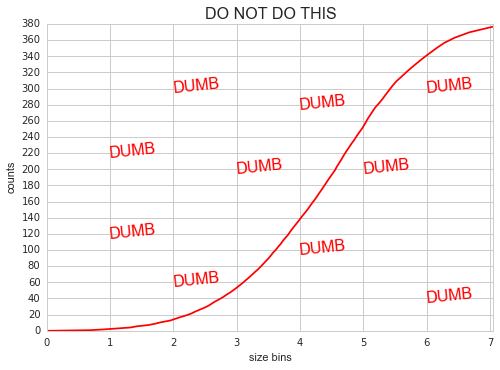

In [152]:
never_again = np.cumsum(lbins_uv)
plt.plot(lbin_edges_uv, never_again, color='r', label="uneven")
plt.xlim(0,ltop)
plt.xlabel("size bins")
plt.yticks(np.arange(0,400,20))
plt.ylim(0,380)
plt.ylabel("counts")
for x,y in (zip(range(1,7), [220,300,200,100,200,40])):
    plt.annotate("DUMB",(x,y),color="r", fontsize=16, rotation=6)
plt.annotate("DUMB",(1,120),color="r", fontsize=16, rotation=6)
plt.annotate("DUMB",(2,60),color="r", fontsize=16, rotation=6)
plt.annotate("DUMB",(4,280),color="r", fontsize=16, rotation=6)
plt.annotate("DUMB",(6,300),color="r", fontsize=16, rotation=6)
plt.title("DO NOT DO THIS", fontsize=16)
plt.show()

This is even worse when you think that the unit I'm using is 770 firms in each bin (not workers). I was adding averages of workers. This makes it even more confusing and dumb.

## 5. Corrected version

My most recent "Best fit" parameters deliver, when comapred with the corrected code:

Success! All workers and firms are matched


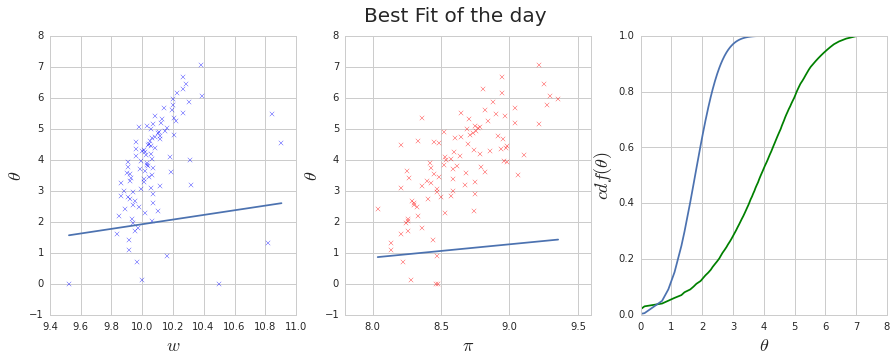

In [153]:
besties = (0.63023927,  0.8037265,   0.67336212,  1.33407531)
# try it out   
F_params = {'omega_A':besties[0], 'omega_B':besties[1], 'sigma_A':besties[2], 'Big_A':besties[3]}
functions_f_model = est1.Solve_Model(F_params, None, 'lsoda', 1e3, 1e-3)
est1.Plot_solution()

Which means that at least the model is equally disastrous in all aspects :)